In [21]:
#https://github.com/InsulatorData/InsulatorDataSet
#https://universe.roboflow.com/mingrui-yu/insulatordataset-nmard/dataset/1/download - он же.

In [22]:
! pip install torchmetrics

In [23]:
! pip install pycocotools

In [24]:
%load_ext autoreload
from torchvision.datasets import VOCDetection
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
from pathlib import Path
import torchvision.datasets as datasets
import torchvision

import torch
from PIL import Image
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.ops.boxes import nms
from pprint import pprint
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import copy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
MODEL_PATH='/kaggle/working/model.pt'

In [26]:
train_dataset = VOCDetection(str('../input/insulatordataset/InsulatorDataSetForKaggle/InsulatorDataSet/Normal_Insulators'),year="2007",image_set='train')
val_dataset = VOCDetection(str('../input/insulatordataset/InsulatorDataSetForKaggle/InsulatorDataSet/Normal_Insulators'),year="2007",image_set='test')
test37_dataset = VOCDetection(str('../input/insulatordataset/test_37pics_voc_format_for_kaggle/test_37pics_voc_format'),year="2007",image_set='train')



In [27]:
train_dataset, val_dataset,test37_dataset

(Dataset VOCDetection
     Number of datapoints: 449
     Root location: ../input/insulatordataset/InsulatorDataSetForKaggle/InsulatorDataSet/Normal_Insulators,
 Dataset VOCDetection
     Number of datapoints: 151
     Root location: ../input/insulatordataset/InsulatorDataSetForKaggle/InsulatorDataSet/Normal_Insulators,
 Dataset VOCDetection
     Number of datapoints: 36
     Root location: ../input/insulatordataset/test_37pics_voc_format_for_kaggle/test_37pics_voc_format)

In [28]:
# from os import listdir
# from os.path import isfile, join
# mypath = '/home/serhio/Data/1Education/Hack_Insulators/InsulatorDataSet/Normal_Insulators/VOCdevkit/VOC2007/JPEGImages'#str(Path(os.getcwd())/'InsulatorDataSet/Normal_Insulators')
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# for x in onlyfiles:
#     print(x[:-4])

In [29]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [30]:
# info = train_dataset[2][1]
# info['annotation']['object']

In [31]:
def pil_to_tensor(pil_image):
    return torch.from_numpy(np.asarray(pil_image)/255).permute(2, 0, 1).to(torch.float)


def info_to_dict(info):
    boxes = []
    objects_cnt = len(info['annotation']['object'])
    for object_dict in info['annotation']['object']:  # ['xmin', 'ymin', 'xmax' , 'ymax']
        # raise ValueError(object_dict)
        bbox = [
            int(object_dict['bndbox']['xmin']),
            int(object_dict['bndbox']['ymin']),
            int(object_dict['bndbox']['xmax']),
            int(object_dict['bndbox']['ymax'])
        ]
        boxes.append(bbox)
    # raise ValueError(boxes)
    boxes = torch.Tensor(boxes).to(torch.float)
    labels = torch.Tensor([1]*objects_cnt).to(torch.int64)
    return {'boxes': boxes, 'labels': labels}


info_to_dict(train_dataset[0][1])

{'boxes': tensor([[  84.,  260., 1044.,  520.]]), 'labels': tensor([1])}

In [32]:
# from PIL import Image


# def show_object_rect(image: np.ndarray, bndbox):
#     pt1 = bndbox[:2]
#     pt2 = bndbox[2:]
#     image_show = image
#     return cv2.rectangle(image_show, pt1, pt2, (0, 255, 255), 2)


# def show_object_name(image: np.ndarray, name: str, p_tl):
#     return cv2.putText(image, name, p_tl, 1, 1, (255, 0, 0))


# voc_trainset = test37_dataset
# for i, sample in enumerate(voc_trainset, 1):
#     image, annotation = sample[0], sample[1]['annotation']
#     objects = annotation['object']
#     show_image = np.array(image)
#     # print('{} object:{}'.format(i, len(objects)))
#     if not isinstance(objects, list):
#         object_name = objects['name']
#         object_bndbox = objects['bndbox']
#         x_min = int(object_bndbox['xmin'])
#         y_min = int(object_bndbox['ymin'])
#         x_max = int(object_bndbox['xmax'])
#         y_max = int(object_bndbox['ymax'])
#         show_image = show_object_rect(show_image, (x_min, y_min, x_max, y_max))
#         show_image = show_object_name(show_image, object_name, (x_min, y_min))
#     else:
#         for j in objects:
#             object_name = j['name']
#             object_bndbox = j['bndbox']
#             x_min = int(object_bndbox['xmin'])
#             y_min = int(object_bndbox['ymin'])
#             x_max = int(object_bndbox['xmax'])
#             y_max = int(object_bndbox['ymax'])
#             show_image = show_object_rect(
#                 show_image, (x_min, y_min, x_max, y_max))
#             show_image = show_object_name(
#                 show_image, object_name, (x_min, y_min))

#     # Image.fromarray(show_image).show()
#     # img = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)
#     # im_pil = Image.fromarray(img)
#     # im_pil.show()
#     cv2.imshow('image', show_image)
#     cv2.waitKey(0)


# print(voc_trainset)
# print('Down load ok')

In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# train_dataset = MyDataset(df_train, '/content/table-detection-dataset/images')
# val_dataset = MyDataset(df_val, '/content/table-detection-dataset/images')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test37_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [35]:
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = map(pil_to_tensor, images)
        targets = map(info_to_dict, targets)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация (батч) #{i} loss: {loss}")
#         if i==1:
#             break# TODO delete for full run
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    metric = MeanAveragePrecision()
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = map(pil_to_tensor, images)
        targets = map(info_to_dict, targets)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
            model.eval()
            preds = model(images)
            model.train()
            metric.update(preds, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    map_value = metric.compute()["map"].item()  
    return val_loss, map_value

In [36]:
import time

best_map_value = 0
best_model = None

train_losses = []
val_losses = []
try:
    for epoch in range(20):
        start = time.time()
        train_loss =train(train_data_loader)
        val_loss, map_value = val(val_data_loader)
        print(f'MAP: {round(map_value,3)} ')
        if map_value>best_map_value:
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), MODEL_PATH)
            print(f"Saved best model")
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')
    


	Итерация (батч) #0 loss: 1.5996053218841553
	Итерация (батч) #50 loss: 0.2663862407207489
	Итерация (батч) #100 loss: 0.18957564234733582
MAP: 0.296 
Saved best model
Эпоха #0 train_loss: 0.08920957717239723, val_loss: 0.0645722190769303
Потрачено 2.9 минут на 0 эпоху
	Итерация (батч) #0 loss: 0.24006959795951843
	Итерация (батч) #50 loss: 0.14736878871917725
	Итерация (батч) #100 loss: 0.2631753087043762
MAP: 0.435 
Saved best model
Эпоха #1 train_loss: 0.05728037071254577, val_loss: 0.051413521861398456
Потрачено 2.8 минут на 1 эпоху
	Итерация (батч) #0 loss: 0.1018088310956955
	Итерация (батч) #50 loss: 0.07566668093204498
	Итерация (батч) #100 loss: 0.10917359590530396
MAP: 0.624 
Saved best model
Эпоха #2 train_loss: 0.04683143133608695, val_loss: 0.047527716131202435
Потрачено 2.8 минут на 2 эпоху
	Итерация (батч) #0 loss: 0.1559533327817917
	Итерация (батч) #50 loss: 0.12002366781234741
	Итерация (батч) #100 loss: 0.0993119329214096
MAP: 0.66 
Saved best model
Эпоха #3 train_lo

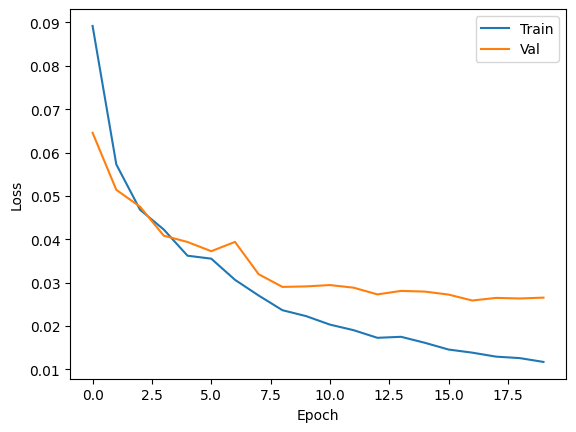

In [37]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = create_model(num_classes=2, pretrained=False).to(device)
best_model.load_state_dict(torch.load(MODEL_PATH))
model = best_model

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpb1dfa683.PNG'


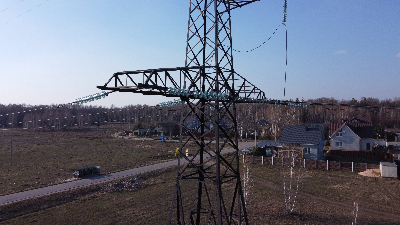

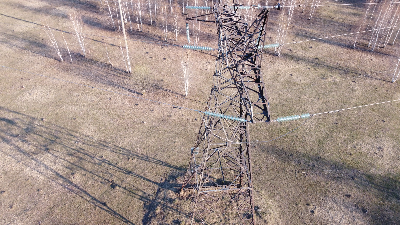

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpkhzm6uwz.PNG'


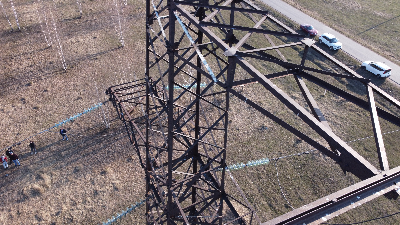

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpiu1ovh1m.PNG'


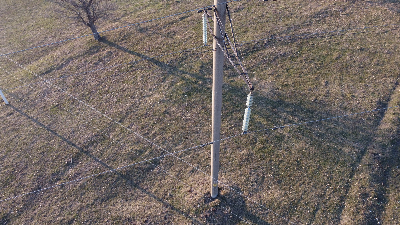

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpn1v1tt0a.PNG'
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found


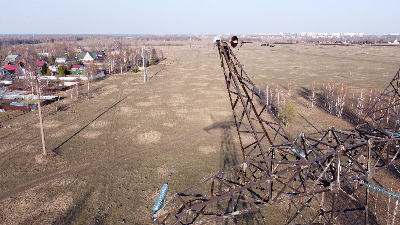

/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpydcx957a.PNG'


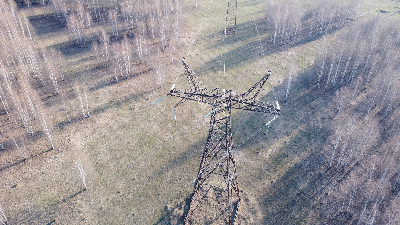

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpbbkgeyzs.PNG'


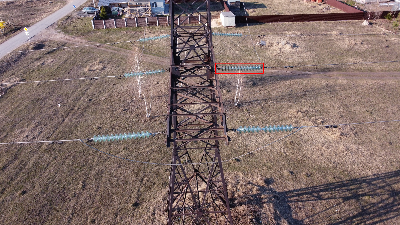

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpk93mpb84.PNG'


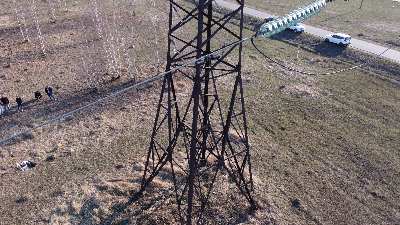

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp5idvzktu.PNG'


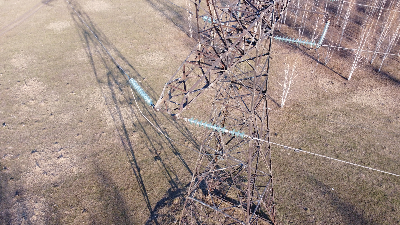

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpkstoc23w.PNG'


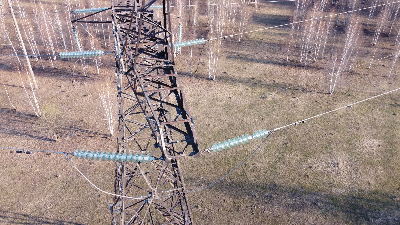

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpw4zb9y_h.PNG'


In [42]:
iou_threshold=0.1
threshold=0.8
scale_percent=10
def predict_and_draw(obj):
    model.eval()
    img_pil, info = obj
    img = np.asarray(img_pil)
    img_ = img/ 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
            if predict[0]['scores'][i] > threshold:
                cv2.rectangle(img, 
                        (int(box[0]), int(box[1])), 
                        (int(box[2]), int(box[3])), 
                        (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    # cv2_imshow(img)
    PIL_image = Image.fromarray(img.astype('uint8'), 'RGB')
    PIL_image.show()
    return PIL_image

from IPython.display import display


for x in range(10):
    display(predict_and_draw(test37_dataset[x]))
#     display(predict_and_draw(val_dataset[x]))
    



In [40]:
_, map_value = val(test_data_loader)
print(f"MAP on TEST {map_value}")

MAP on TEST 0.010144014842808247
